# Data Processing & Cleaning for Exploratory Data Analysis

In [1]:
# The following Python packages will be used for data formatting and visualizations for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
SRDataset = pd.read_csv("D:/Programming/dataset.csv")
SRDataset.shape
SRDataset = SRDataset.sample(n = 641710, random_state = 42) # Since the original dataset has 6,417,106 rows, we will only sample 10% of it to lower the overall computational complexity 

In [3]:
SRDataset = SRDataset[SRDataset["review_votes"] == 1] # To ensure as much reliability as possible, we will only work with reviews that have been recommended by other users
SRDataset = SRDataset.drop("review_votes", axis = 1) # Unused column

SRDataset.dropna(inplace = True) # Remove all rows with missing information
SRDataset = SRDataset.drop_duplicates() # Remove duplicate rows to avoid inaccuracy/bias

SRDataset = SRDataset[~SRDataset['review_text'].str.contains("Early Access Review", case = True)] # We will remove preliminary reviews to ensure that there is no recency bias
SRDataset = SRDataset[~SRDataset['review_text'].str.contains("[^A-Za-z0-9 .,;:'\"!?()%-/“”‘’]", regex = True)] # Remove all reviews containing ASCII art since it cannot be processed properly for NLP
SRDataset.shape

(59262, 4)

In [4]:
SRDataset.rename(columns = {"app_id": "Steam ID"}, inplace = True) # Unique ID for game lookups on Steam
SRDataset.rename(columns = {"app_name": "Title"}, inplace = True)
SRDataset.rename(columns = {"review_text": "User Review"}, inplace = True)
SRDataset.rename(columns = {"review_score": "Review Score (Actual)"}, inplace = True) # In this dataset, this is our target for the ML predictions
SRDataset.head(10)

,Steam ID,Title,User Review,Review Score (Actual)
301327,12210,Grand Theft Auto IV: The Complete Edition,Best bowling simulator 2014 10/10 It has good ...,1
2131870,238370,Magicka 2,'Spell Trickshot Simulator' 11/10,1
2059407,236390,War Thunder,how do i fix warthunder it says it cant downlo...,1
6088137,570,Dota 2,nice game ever,1
3235424,270550,Yet Another Zombie Defense,This game is the s to the h to the i to the t ...,1
5392393,417860,Emily is Away,It was a pretty short and basic game its story...,1
4853256,373630,Game Type,"Girl Fight is a shoot 'em up a lot of fun, cr...",1
5362235,41070,Serious Sam 3: BFE,I wanted to love this game because the earlier...,-1
3329323,273350,Evolve Stage 2,It's a really good game that happens to be tar...,1
5708516,466500,35MM,Could not find a bucket.,-1


---

# Text Preprocessing and Vectorization for NLP

In [5]:
import nltk
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer

In [6]:
english_stopwords = set(stopwords.words('english')) # Words such as "the", "and", "is", etc

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text) # Removes all characters that are not letters, digits, or spaces
    words = text.split() # Splits the provided text into a list of strings
    words = [word for word in words if word not in english_stopwords and word != ""] # Removes all stopwords and empty strings
    return ' '.join(words) # Converts the list back into a single string

SRDataset['NLP-Processed Text'] = SRDataset['User Review'].apply(preprocess_text)

In [7]:
tfidf_vectorizer = TfidfVectorizer() # Used to convert the processed text into a numerical format that the computer can understand
tfidf_matrix = tfidf_vectorizer.fit_transform(SRDataset["NLP-Processed Text"])
SRDataset.head(10)

,Steam ID,Title,User Review,Review Score (Actual),NLP-Processed Text
301327,12210,Grand Theft Auto IV: The Complete Edition,Best bowling simulator 2014 10/10 It has good ...,1,best bowling simulator 2014 1010 good storyline
2131870,238370,Magicka 2,'Spell Trickshot Simulator' 11/10,1,spell trickshot simulator 1110
2059407,236390,War Thunder,how do i fix warthunder it says it cant downlo...,1,fix warthunder says cant download update tryed...
6088137,570,Dota 2,nice game ever,1,nice game ever
3235424,270550,Yet Another Zombie Defense,This game is the s to the h to the i to the t ...,1,game h yooo
5392393,417860,Emily is Away,It was a pretty short and basic game its story...,1,pretty short basic game story wasnt complicate...
4853256,373630,Game Type,"Girl Fight is a shoot 'em up a lot of fun, cr...",1,girl fight shoot em lot fun crazy dynamic
5362235,41070,Serious Sam 3: BFE,I wanted to love this game because the earlier...,-1,wanted love game earlier serious sams favorite...
3329323,273350,Evolve Stage 2,It's a really good game that happens to be tar...,1,really good game happens targeted v like real ...
5708516,466500,35MM,Could not find a bucket.,-1,could find bucket


---

 # Exploratory Data Analysis (EDA)

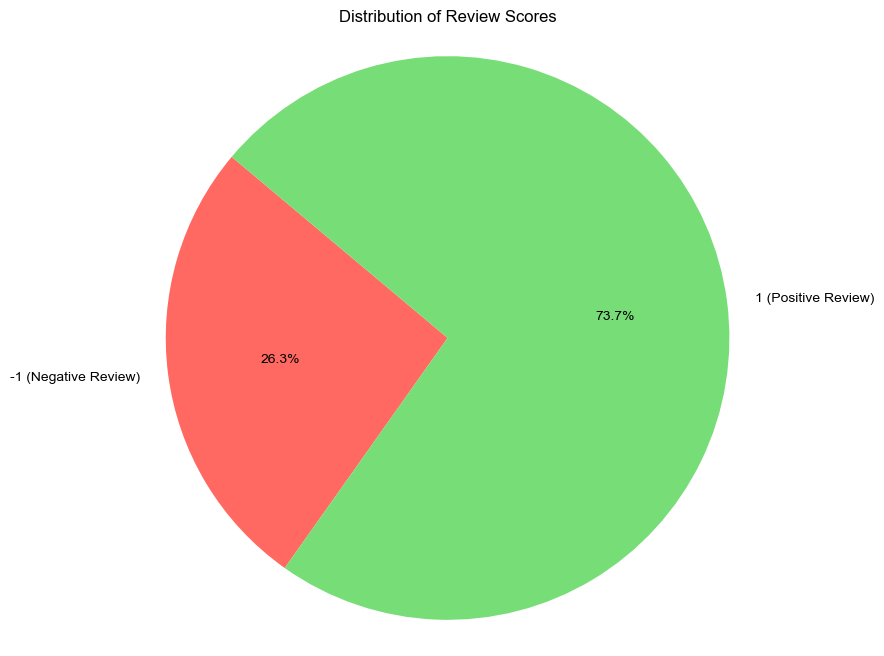

In [8]:
review_summary = SRDataset[SRDataset['Review Score (Actual)'].isin([-1, 1])].groupby('Review Score (Actual)').size().reset_index(name = 'Count')
review_summary['Percentage'] = review_summary['Count'] / review_summary['Count'].sum() * 100

colors = ['#ff6961', '#77dd77']

plt.figure(figsize=(8, 8))
plt.pie(review_summary['Percentage'], labels = ['-1 (Negative Review)', '1 (Positive Review)'], autopct = '%1.1f%%', startangle = 140, colors = colors)
plt.title("Distribution of Review Scores")

sns.set_style("whitegrid")

plt.axis('equal')
plt.show()

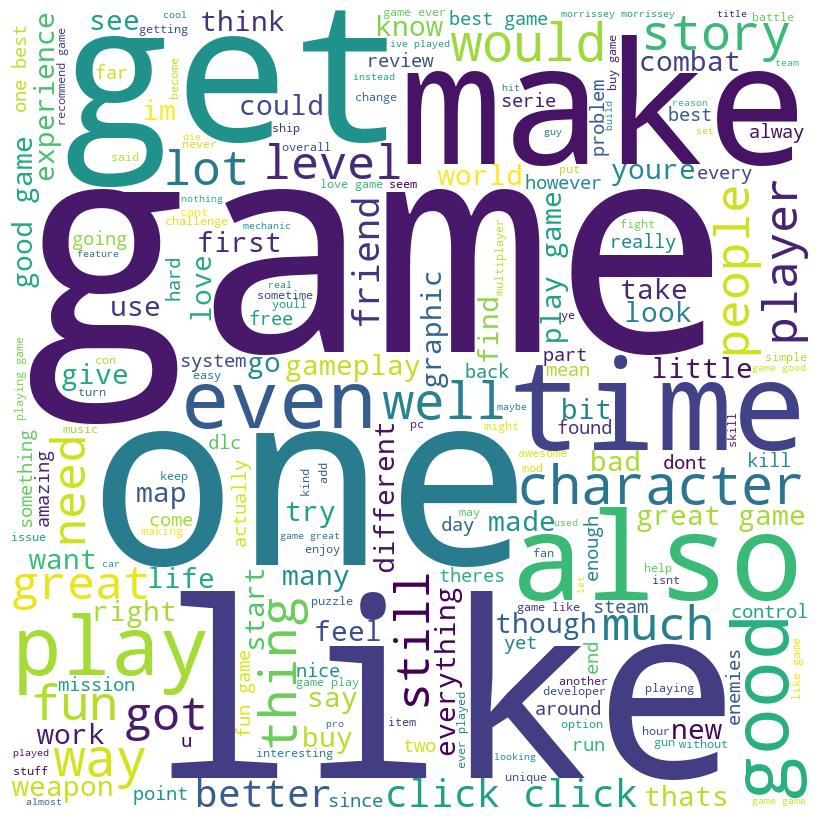

In [9]:
# Most common words found in positive reviews
positive_reviews = SRDataset[SRDataset['Review Score (Actual)'] == 1]['NLP-Processed Text'].str.cat(sep=' ')

wordcloud_pos = WordCloud(width=800, height=800, 
                background_color = 'white', 
                stopwords = english_stopwords, 
                min_font_size = 10).generate(positive_reviews)
                   
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_pos) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

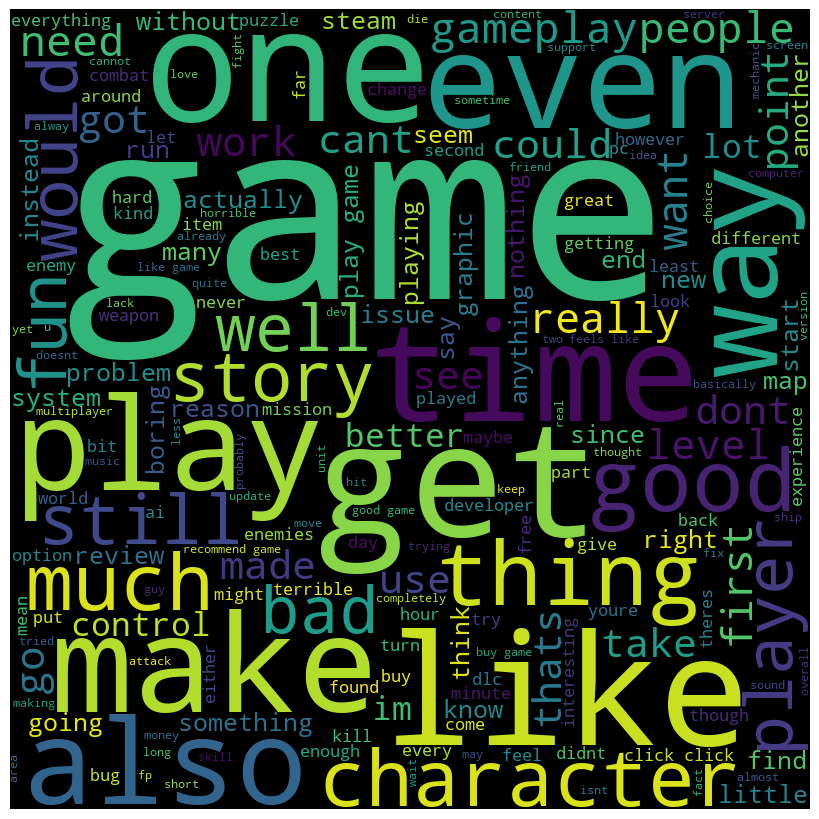

In [10]:
# Most common words found in negative reviews
negative_reviews = SRDataset[SRDataset['Review Score (Actual)'] == -1]['NLP-Processed Text'].str.cat(sep=' ')

wordcloud_neg = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = english_stopwords, 
                min_font_size = 10).generate(negative_reviews)
                    
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_neg) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

---

# Model Training & Testing

In [11]:
from sklearn.model_selection import train_test_split

y = SRDataset['Review Score (Actual)'].values # Target for ML predictions
X = tfidf_matrix # Feature used for ML predictions

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42) # 20% of the data will be used for testing, and 80% will be used for training

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter = 1000),
    "Naive Bayes": MultinomialNB(), # Multinomial NB variant used since TF-IDF was applied to the ML feature
}

evaluation_metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": []
}

for name, model in models.items():
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    evaluation_metrics["Model"].append(name)
    evaluation_metrics["Accuracy"].append(accuracy)
    evaluation_metrics["Precision"].append(precision)
    evaluation_metrics["Recall"].append(recall)
    evaluation_metrics["F1 Score"].append(f1)


results_df = pd.DataFrame(evaluation_metrics)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.846705,0.855455,0.954752,0.902380
1,Naive Bayes,0.756602,0.753974,0.997499,0.858807


---

# Hyperparameter Tuning & Optimization

### Since the total accuracy and precision was found to be lower than expected for Naive Bayes, we can use hyperparameter tuning and optimization to boost the metrics of both base models before ensembling.

In [13]:
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore') # We will be ignoring the warnings that Python automatically gives when performing randomized searches

param_grid_lr = {
    'C': [2.129, 2.1291, 2.1922, 2.1923, 2.1924, 2.1925], # Manually adjusted to ensure total accuracy
    'solver': ['liblinear', 'saga']
}

param_grid_nb = {
    'alpha': [0.1, 0.11, 0.12, 0.13, 0.14, 0.15] # Manually adjusted to ensure total accuracy
}

random_searches = {
    "Logistic Regression": RandomizedSearchCV(LogisticRegression(max_iter = 1000), param_grid_lr, n_iter = 50, cv = 10, scoring = 'accuracy', verbose = 1, random_state = 42),
    "Naive Bayes": RandomizedSearchCV(MultinomialNB(), param_grid_nb, n_iter = 50, cv = 10, scoring = 'accuracy', verbose = 1, random_state = 42)
}
# Random Search used instead of Grid Search to lower computational complexity
for model_name, random_search in random_searches.items(): # Using Random Search to find the best parameters for the ensemble model 
    print(f"Starting Random Search for {model_name}")
    random_search.fit(X_train, y_train)
    print(f"Best Parameters for {model_name}: {random_search.best_params_}")
    print(f"Best Score for {model_name}: {random_search.best_score_}")

Starting Random Search for Logistic Regression
Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best Parameters for Logistic Regression: {'solver': 'liblinear', 'C': 2.1922}
Best Score for Logistic Regression: 0.8478769812133494
Starting Random Search for Naive Bayes
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best Parameters for Naive Bayes: {'alpha': 0.1}
Best Score for Naive Bayes: 0.8125040293979175


### Now that we found the best hyperparameters through tuning the base models, we can now use them to optimize the ensemble model of the two base models.

In [14]:
from sklearn.ensemble import StackingClassifier
from scipy.stats import uniform

base_learners = [
    ('lr', LogisticRegression(max_iter = 1000, C = 2.129, solver = 'saga')),
    ('nb', MultinomialNB(alpha=0.1))
]

final_estimator = LogisticRegression(max_iter = 1000)

stacking_clf = StackingClassifier(estimators = base_learners, final_estimator = final_estimator) # Using tuned hyperparameters for the stacking classifier to maximize all metrics

params = {
    'final_estimator__C': uniform(loc = 0, scale = 4),
    'final_estimator__solver': ['liblinear', 'saga']
}

random_search = RandomizedSearchCV(estimator = stacking_clf, param_distributions = params, n_iter = 100, cv = 5, verbose = 2, random_state = 42, scoring = 'accuracy')

random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END final_estimator__C=1.49816047538945, final_estimator__solver=liblinear; total time=   3.2s
[CV] END final_estimator__C=1.49816047538945, final_estimator__solver=liblinear; total time=   3.0s
[CV] END final_estimator__C=1.49816047538945, final_estimator__solver=liblinear; total time=   2.8s
[CV] END final_estimator__C=1.49816047538945, final_estimator__solver=liblinear; total time=   3.1s
[CV] END final_estimator__C=1.49816047538945, final_estimator__solver=liblinear; total time=   3.1s
[CV] END final_estimator__C=0.7337391594646552, final_estimator__solver=saga; total time=   3.1s
[CV] END final_estimator__C=0.7337391594646552, final_estimator__solver=saga; total time=   2.9s
[CV] END final_estimator__C=0.7337391594646552, final_estimator__solver=saga; total time=   3.0s
[CV] END final_estimator__C=0.7337391594646552, final_estimator__solver=saga; total time=   3.1s
[CV] END final_estimator__C=0.7337391594646552, f

---

# Model Ensembling

### Now that we optimized the Stacking Classifier, we can now finally use it for model ensembling and record the final metrics for the sentiment analysis.

In [15]:
base_learners = [
    ('lr', LogisticRegression(max_iter=1000)),
    ('nb', MultinomialNB())
]

final_estimator = LogisticRegression() # Since LR had the highest accuracy and precision, we will be using it as our estimator for the stacking classifier

stacking_clf = StackingClassifier(estimators = base_learners, final_estimator = final_estimator)

stacking_clf.set_params(**random_search.best_params_) # Using the most accurate parameters found from hyperparameter optimization 
stacking_clf.fit(X_train, y_train)

predictions = stacking_clf.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f'Accuracy: {accuracy}') # Approximately 84.85%
print(f'Precision: {precision}') # Approximately 86.86%
print(f'Recall: {recall}') # Approximately 93.77%
print(f'F1 Score: {f1}') # Approximately 90.19%

Accuracy: 0.8484771787733063
Precision: 0.8685762426284751
Recall: 0.9376989540700318
F1 Score: 0.9018150010933742
